In [1]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from sklearn.cross_validation import train_test_split
from sklearn import datasets
from keras.optimizers import SGD
from keras.utils import np_utils
import numpy as np
from skimage import io
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

Using TensorFlow backend.
/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
GTS_IND_LIST  = [1,3,5,7,11,13,15,17,21,23,26,28,30,32,34,37] 
TEST_IND_LIST = [1,7,15,32]
TRAIN_IND_LIST = [i for i in GTS_IND_LIST if not i in TEST_IND_LIST]

MAIN_PATH = "/Users/ekaterina/Documents/Semantic Segmentation/ISPRS_semantic_labeling_Vaihingen"
TOP_FORMAT = "/top/top_mosaic_09cm_area{}.tif"
SLIC_RES_FORMAT = "/Output/SLIC/{}_area_{}_segm.txt"
GTS_FORMAT = "/gts_for_participants/top_mosaic_09cm_area{}.tif"
NDSM_FORMAT = "/ndsm/ndsm_09cm_matching_area{}.bmp"

#FEATURES_FORMAT = "/Output/FEATURES_WITH_NEIGHBOURS/{}_area_{}_segm.txt"
FEATURES_FORMAT = "/Output/FEATURES/{}_area_{}_segm.txt"
LABELS_FORMAT = "/Output/LABELS/{}_area_{}_segm.txt"
ADJ_GRAPH_FORMAT = "/Output/ADJ_GRAPHS/{}_area_{}_segm.txt"

CLASSES_NUM = 6

SEGM_MAX_NUM = 30000

FEATURES_NUM = 20

BATCH_SIZE = 200

CONV_W = 2
POOL_W = 2
NUER_1 = 20
NEUR_2 = 50
EPOCH = 20

categories = np.zeros((6, 3), dtype = 'uint8')
categories[0]  = [255, 255, 255]
categories[1]  = [0, 0, 255]
categories[2]  = [0, 255, 255]
categories[3]  = [0, 255, 0]
categories[4]  = [255, 255, 0]
categories[5]  = [255, 0, 0]

In [3]:
def get_slic_res(num, seg_num):
    res_path = MAIN_PATH + SLIC_RES_FORMAT.format(num, seg_num)
    res = np.loadtxt(res_path, dtype = "int")
    return res

In [4]:
def get_gts(num):
    label_path = MAIN_PATH + GTS_FORMAT. format(num)
    res = io.imread(label_path)
    return res

In [5]:
def convert_labels_to_color(label_map):
    color_map = np.zeros((label_map.shape[0],label_map.shape[1], 3), dtype = 'uint8')
    for i in range(label_map.shape[0]):
        for j in range (label_map.shape[1]):
            for k in range(6):
                if label_map[i][j] == k:
                    color_map[i][j] = categories[k]
                    break
                    
    return color_map

In [6]:
def convert_color_to_labels(color_map):
    label_map = np.zeros((color_map.shape[0],color_map.shape[1]), dtype = 'uint8')
    for i in range(color_map.shape[0]):
        for j in range (color_map.shape[1]):
            pics = color_map[i][j][:]
            for k in range(6):
                if np.array_equal(pics, categories[k, :]):
                    label_map[i][j] = k
                    break
    return label_map

In [7]:
def show_pic(pic):
    io.imshow(pic)
    io.show()

In [8]:
def make_data_plain(data, features_num):
    plain_data = data.copy()
    plain_data.resize(data.shape[0]*data.shape[1], features_num)
    return plain_data

In [9]:
print("Loading features")
train_data = np.zeros((0, FEATURES_NUM), dtype = 'float64')
train_labels = np.zeros(0, dtype = 'uint8')
test_data = np.zeros((0, FEATURES_NUM), dtype = 'float64')
test_labels = np.zeros(0, dtype = 'uint8')
for i in TRAIN_IND_LIST:
    print("Loading area ", i)
    train_data = np.concatenate((train_data, np.loadtxt(MAIN_PATH + FEATURES_FORMAT.format(i,SEGM_MAX_NUM), dtype = 'float64')))
    train_labels = np.concatenate((train_labels, np.loadtxt(MAIN_PATH + LABELS_FORMAT.format(i,SEGM_MAX_NUM), dtype = 'uint8')))
    
for i in TEST_IND_LIST:
    print("Loading area ", i)
    test_data = np.concatenate((test_data, np.loadtxt(MAIN_PATH + FEATURES_FORMAT.format(i,SEGM_MAX_NUM), dtype = 'float64')))
    test_labels = np.concatenate((test_labels, np.loadtxt(MAIN_PATH + LABELS_FORMAT.format(i,SEGM_MAX_NUM), dtype = 'uint8')))

Loading features
Loading area  3
Loading area  5
Loading area  11
Loading area  13
Loading area  17
Loading area  21
Loading area  23
Loading area  26
Loading area  28
Loading area  30
Loading area  34
Loading area  37
Loading area  1
Loading area  7
Loading area  15
Loading area  32


In [10]:
train_labels = np_utils.to_categorical(train_labels, CLASSES_NUM)
test_labels = np_utils.to_categorical(test_labels, CLASSES_NUM)

In [11]:
train_data = train_data.reshape((train_data.shape[0], 1, FEATURES_NUM))
train_data = train_data[:, :, :,np.newaxis]

In [12]:
test_data = test_data.reshape((test_data.shape[0], 1, FEATURES_NUM))
test_data = test_data[:, :, :,np.newaxis]

In [13]:
CNN = Sequential()

CNN.add(Convolution2D(NUER_1, (1, CONV_W), input_shape=(1, FEATURES_NUM, 1), padding="same"))
CNN.add(Activation("relu"))
CNN.add(MaxPooling2D(pool_size=(1, POOL_W), strides=(1, POOL_W)))

CNN.add(Convolution2D(NEUR_2, (1, CONV_W), padding="same"))
CNN.add(Activation("relu"))
CNN.add(MaxPooling2D(pool_size=(1, POOL_W), strides=(1, POOL_W)))

CNN.add(Flatten())
CNN.add(Dense(500))
CNN.add(Activation("relu"))

CNN.add(Dense(CLASSES_NUM))
CNN.add(Activation("softmax"))

In [14]:
opt = SGD(lr=0.01)
CNN.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

In [15]:
CNN.fit(train_data, train_labels, batch_size=BATCH_SIZE, nb_epoch=EPOCH, verbose=1)

/usr/local/lib/python3.6/site-packages/keras/models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/20
332972/332972 [==============================] - 18s - loss: 0.7900 - acc: 0.7599       

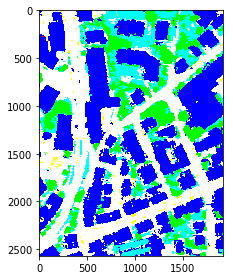

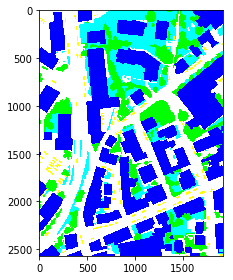

F1 res =  0.915972406253
Acc res =  0.932402227951


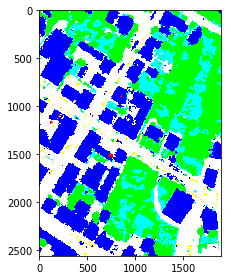

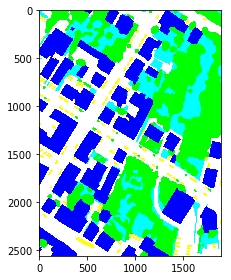

F1 res =  0.908231787022
Acc res =  0.919611552936


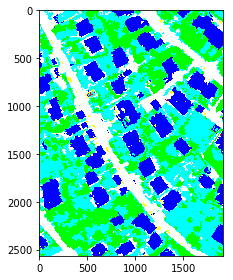

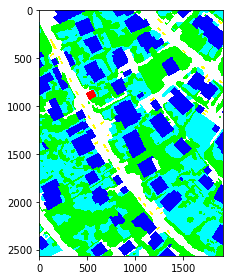

F1 res =  0.888520570688
Acc res =  0.902844744308


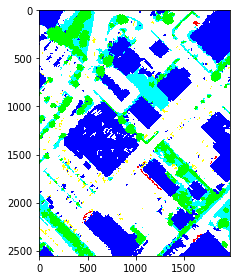

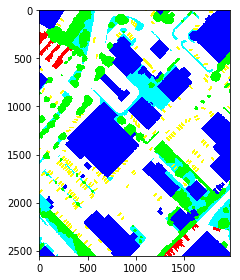

F1 res =  0.891264619459
Acc res =  0.935183340252


In [16]:
for j in TEST_IND_LIST:
    testData = np.loadtxt(MAIN_PATH + FEATURES_FORMAT.format(j,SEGM_MAX_NUM), dtype = 'float64')
    testData = testData.reshape((testData.shape[0], 1, 20))
    testData = testData[:, :, :,np.newaxis]
    predicted_plain_labels = CNN.predict(testData)
    predicted_plain_labels = predicted_plain_labels.argmax(axis=1)
    mask = get_slic_res(j, SEGM_MAX_NUM)
    for i in range(mask.shape[0]):
        for k in range(mask.shape[1]):
            mask[i][k] = predicted_plain_labels[mask[i][k]]
    test_label_map = get_gts(j)
    predicted_pic = convert_labels_to_color(mask)
    io.imsave(MAIN_PATH + "/Output/RES_CNN/Predicted labels for {}_CNN_last.jpg".format(j), predicted_pic)
    show_pic(predicted_pic)
    show_pic(test_label_map)
    predicted_pic = make_data_plain(predicted_pic,1)
    test_label_map = make_data_plain(test_label_map,1)
    f1_res = f1_score(test_label_map, predicted_pic, labels = [0,1,2,3,4,5], average = 'micro')
    print("F1 res = ",f1_res, )
    acc_res = accuracy_score(test_label_map, predicted_pic )
    print("Acc res = " ,acc_res)